# **Skin Lesion Analyzer with Deep Learning**



### **Outline**
Use these links to jump to specific sections of this project.

1. Import Packages
2. Load and Transform the Dataset
3. Model Development
4. Model Training 
5. Prediction and Evaluation

### 1. Import Packages

In [6]:
import os
import glob
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import DenseNet121

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

### 2. Load and Transform the Dataset

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE


class DatasetBuilder():
    def __init__(self, base_dir, csv_file):
        self.base_dir = base_dir
        self.csv_file = csv_file
        
    def transform_df(self, base_dir, csv_file):
        df = pd.read_csv(csv_file)
        image_path_dict = {os.path.splitext(os.path.basename(x))[0]: x 
                       for x in glob.glob(os.path.join(base_dir, '*', '*.jpg'))}
        label_dict = {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3,
                      'mel': 4, 'nv': 5, 'vasc': 6}
        df['image_path'] = df['image_id'].map(image_path_dict.get)
        df['label_id'] = df['dx'].map(label_dict.get)
        return df
    
    def split_df(self):
        dataframe = self.transform_df(self.base_dir, self.csv_file)
        train_df, val_df = train_test_split(dataframe, test_size=0.15)
        train_df, test_df = train_test_split(train_df, test_size=0.10)
        return train_df, val_df, test_df
    
    def get_labels(self, dataframe):
        label_list = dataframe.label_id.values
        labels = to_categorical(label_list, num_classes=7)
        return labels
    
    def decode_image(self, filename, label=None, image_size=(224, 224)):
        bits = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(bits, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, image_size)
        return image, label
    
    def input_fn(self, dataframe, batch_size=32, mode=None):
        image_list = dataframe.image_path.values
        labels = self.get_labels(dataframe)
        ds = (tf.data.Dataset     
                .from_tensor_slices((image_list, labels))
                .map(self.decode_image, num_parallel_calls=AUTOTUNE)
                .cache()
                .repeat()
                .shuffle(buffer_size = 10 * batch_size)
                .batch(batch_size)
                .prefetch(AUTOTUNE))
        return ds

    def create_dataset(self):
        train_df, val_df, test_df = self.split_df()
        train_ds = self.input_fn(train_df)
        val_ds = self.input_fn(val_df)
        return train_ds, val_ds

### 3. Model Development

In [8]:
image_shape = (224, 224, 3)
base_learning_rate = 0.0001

base_model = DenseNet121(input_shape=image_shape, 
                         include_top=False,
                         weights='imagenet')
base_model.trainable = True

image_input = keras.Input(shape=image_shape)
x = base_model(image_input)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(7, activation='softmax')(x)
model = keras.Model(inputs=image_input, outputs=x)

model.compile(optimizer=keras.optimizers.Adam(lr=base_learning_rate/10),
                loss=keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

29089792/29084464 [==============================] - 1s 0us/step


### 4. Model Training

In [9]:
def train_and_evaluate(params):
    csv_file = params['csv_file']
    base_dir = params['base_dir']
    batch_size = params['batch_size']
    num_epochs = params['num_epochs']
    train_steps = params['train_steps']
    val_steps = params['val_steps']

    builder = DatasetBuilder(base_dir, csv_file)
    train_ds, val_ds = builder.create_dataset()
    
    history = model.fit(train_ds,
                        batch_size=batch_size,
                        epochs=num_epochs,
                        validation_data=val_ds,
                        steps_per_epoch=train_steps,
                        validation_steps=val_steps)
    return history

In [10]:
params = {
    'csv_file': '../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv',
    'base_dir': '../input/skin-cancer-mnist-ham10000',
    'batch_size': 32,
    'num_epochs': 10,
    'train_steps': 239,
    'val_steps': 46
}

In [11]:
train_and_evaluate(params)

Epoch 1/10
239/239 [==============================] - 185s 772ms/step - loss: 1.6331 - accuracy: 0.5669 - val_loss: 1.6347 - val_accuracy: 0.6304
Epoch 2/10
239/239 [==============================] - 177s 739ms/step - loss: 1.4587 - accuracy: 0.7202 - val_loss: 1.4382 - val_accuracy: 0.7480
Epoch 3/10
239/239 [==============================] - 177s 739ms/step - loss: 1.4148 - accuracy: 0.7646 - val_loss: 1.3966 - val_accuracy: 0.7806
Epoch 4/10
239/239 [==============================] - 177s 739ms/step - loss: 1.3779 - accuracy: 0.8027 - val_loss: 1.3862 - val_accuracy: 0.7806
Epoch 5/10
239/239 [==============================] - 177s 739ms/step - loss: 1.3479 - accuracy: 0.8321 - val_loss: 1.3608 - val_accuracy: 0.8145
Epoch 6/10
239/239 [==============================] - 176s 738ms/step - loss: 1.3251 - accuracy: 0.8543 - val_loss: 1.3642 - val_accuracy: 0.8010
Epoch 7/10
239/239 [==============================] - 176s 738ms/step - loss: 1.3032 - accuracy: 0.8774 - val_loss: 1.3481 -

In [36]:
model_export_path = '/content/saved_model'
tf.saved_model.save(model, model_export_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/saved_model/assets


### 5. Prediction and Evaluation 

In [12]:
def preprocess_input(params):
    csv_file = params['csv_file']
    base_dir = params['base_dir']
    
    builder = DatasetBuilder(base_dir, csv_file)
    _, _, test_df = builder.split_df()
    image_list = test_df.image_path.values
    
    image = []
    for img in image_list:
        img2array, _ = builder.decode_image(img)
        img_batch = np.expand_dims(img2array, axis=0)
        image.append(img_batch)
    
    labels = builder.get_labels(test_df)
    images = np.vstack(image)
    return images, labels

In [13]:
test_images, test_labels = preprocess_input(params)

In [14]:
predictions = model.predict(test_images)

In [15]:
y_true = tf.argmax(test_labels, axis=-1)
y_pred = tf.argmax(predictions, axis=-1)

In [19]:
confusion_mtx = confusion_matrix(y_true, y_pred)

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

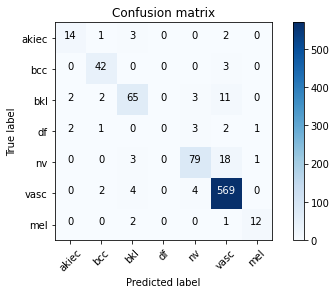

In [21]:
class_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, class_labels)

In [ ]:
FP = confusion_mtx.sum(axis=0) - np.diag(confusion_mtx)  
FN = confusion_mtx.sum(axis=1) - np.diag(confusion_mtx)
TP = np.diag(confusion_mtx)
TN = confusion_mtx.sum() - (FP + FN + TP)

Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
PPV = TP/(TP+FP)
NPV = TN/(TN+FN)

ACC = (TP+TN)/(TP+FP+FN+TN)

In [40]:
columns = ['TP', 'TN', 'FP', 'FN', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'ACC']
performance_metrics = pd.DataFrame(list(zip(TP, TN, FP, FN, Sensitivity, Specificity, PPV, NPV, ACC)), 
                  columns=columns,
                  index=class_labels) 
performance_metrics.round(3)

,TP,TN,FP,FN,Sensitivity,Specificity,PPV,NPV,ACC
akiec,14,828,4,6,0.700,0.995,0.778,0.993,0.988
bcc,42,801,6,3,0.933,0.993,0.875,0.996,0.989
bkl,65,757,12,18,0.783,0.984,0.844,0.977,0.965
df,0,843,0,9,0.000,1.000,NaN,0.989,0.989
nv,79,741,10,22,0.782,0.987,0.888,0.971,0.962
mel,569,236,37,10,0.983,0.864,0.939,0.959,0.945
vasc,12,835,2,3,0.800,0.998,0.857,0.996,0.994
